In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from spacy import displacy
from IPython.display import display, HTML
from collections import Counter
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

c:\Users\Lenovo\OneDrive\Pictures\Tugas A - PBA\ProjectA_TJ-Transjakarta_PBA2025-gasal\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# --- 1. Konfigurasi dan Pemodelan NER (IndoBERT) ---
MODEL_NAME = "cahya/bert-base-indonesian-NER"

# Inisialisasi Tokenizer dan Model IndoBERT
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)
except Exception as e:
    print(f"Error memuat model IndoBERT: {e}")
    print("Pastikan Anda sudah menginstal: pip install transformers datasets torch")
    exit()

# Membuat NER Pipeline (TANPA truncation di inisialisasi)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
print(f"Model NER IndoBERT '{MODEL_NAME}' berhasil dimuat.")

Some weights of the model checkpoint at cahya/bert-base-indonesian-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Model NER IndoBERT 'cahya/bert-base-indonesian-NER' berhasil dimuat.


In [7]:
# --- 2. Fungsi Utama untuk Menjalankan NER ---

def run_ner(text):
    """Mendeteksi entitas bernama dari teks menggunakan IndoBERT (dengan truncation)."""
    if not isinstance(text, str) or pd.isna(text):
        return []
    
    try:
        # Panggil pipeline DENGAN truncation=True
        entities = ner_pipeline(text) 
        
        # Format hasil untuk penyimpanan: (Entitas, Label, Score, Start, End)
        formatted_entities = []
        for e in entities:
            formatted_entities.append({
                'entity': e['word'],
                'label': e['entity_group'],
                'start': e['start'],
                'end': e['end']
            })
        return formatted_entities
    except Exception as e:
        print(f"Warning: Error saat memproses NER pada teks: {e}") 
        return []

In [8]:
# --- 3. Fungsi Post-Processing (Fusion dan Filtering) ---

def merge_adjacent_entities(entities):
    """Menggabungkan entitas yang berdekatan dengan label yang sama (e.g., 'Budi PER Utomo PER')."""
    if not entities:
        return []
    
    # Sortir dan buat salinan list untuk modifikasi
    entities = sorted(entities, key=lambda e: e['start'])
    merged = []
    current_entity = dict(entities[0]) # Gunakan dict() untuk salinan
    
    for next_entity in entities[1:]:
        next_entity = dict(next_entity) # Gunakan dict() untuk salinan
        
        # Cek apakah entitas berdekatan dan memiliki label yang sama
        if next_entity['start'] <= current_entity['end'] + 1 and next_entity['label'] == current_entity['label']:
            # Gabungkan teks dan perbarui posisi end
            # Pastikan tidak ada spasi ganda jika teks memang sudah digabung oleh tokenizer
            current_entity['entity'] += " " + next_entity['entity']
            current_entity['end'] = next_entity['end']
        else:
            merged.append(current_entity)
            current_entity = next_entity
            
    merged.append(current_entity)
    return merged

def filter_and_correct_prd(entities):
    """Menghapus noise dan mengoreksi over-tagging PRD (Product)."""
    corrected = []
    
    # Kata-kata yang TIDAK boleh menjadi PRD, tetapi mungkin ORGANISASI/TRANSPORTASI
    EXCLUDE_PRD = {'bus', 'truk', 'rem', 'rem blong', 'video', 'gambas', 'tj', 'lrt', 'mrt', 'transjakarta'}
    NOISE_ENTITIES = {'SCROLL', 'CONTENT', 'TENT', 'EVT', 'TO', 'CONTIN'}
    
    for e in entities:
        entity_text_lower = e['entity'].lower().strip()
        
        # Hapus noise sisa scraping
        if e['entity'].upper().strip() in NOISE_ENTITIES:
            continue
            
        if e['label'] == 'PRD' and entity_text_lower in EXCLUDE_PRD:
            # Ganti label PRD menjadi ORG untuk nama-nama transportasi utama
            if entity_text_lower in ('mrt', 'lrt', 'transjakarta', 'tj'):
                e['label'] = 'ORG'
            else:
                 continue # Hapus saja kata umum (bus, truk)
        
        # Hapus noise single character yang sering muncul akibat tokenisasi
        if len(e['entity']) <= 1 and e['label'] not in ['PER', 'LOC', 'ORG']:
             continue
             
        corrected.append(e)
    return corrected

In [9]:
# --- 4. Membaca Data dan Menerapkan NER ---
input_filepath = '../Data/hasil_preprocessing_transjakarta.csv' 

try:
    df = pd.read_csv(input_filepath)
    print(f"\nFile '{input_filepath}' berhasil dibaca. Jumlah data: {len(df)} baris.")
except FileNotFoundError:
    print(f"Error: File '{input_filepath}' tidak ditemukan.")
    exit()

print("Memulai proses Named Entity Recognition (NER) pada Teks_Lengkap...")
# Penerapan NER Mentah
df['Entitas_NER_Raw'] = df['Teks_Lengkap'].apply(run_ner)
print("NER Mentah Selesai.")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



File '../Data/hasil_preprocessing_transjakarta.csv' berhasil dibaca. Jumlah data: 150 baris.
Memulai proses Named Entity Recognition (NER) pada Teks_Lengkap...
NER Mentah Selesai.


In [10]:
# A. Gabungkan entitas (Fusion)
df['Entitas_NER_Fused'] = df['Entitas_NER_Raw'].apply(merge_adjacent_entities)
print("Post-Processing: Entitas berhasil digabungkan (Fused).")

# B. Filter dan koreksi PRD
df['Entitas_NER_Final'] = df['Entitas_NER_Fused'].apply(filter_and_correct_prd)
print("Post-Processing: Entitas PRD umum berhasil difilter/dikoreksi.")

Post-Processing: Entitas berhasil digabungkan (Fused).
Post-Processing: Entitas PRD umum berhasil difilter/dikoreksi.


In [11]:
# --- 6. Perhitungan Total Frekuensi Entity Final ---

all_final_labels = []
for index, row in df.iterrows():
    # Loop melalui kolom yang SUDAH DIBERSIHKAN
    for entity in row['Entitas_NER_Final']:
        label = entity.get('label')
        if label:
            all_final_labels.append(label)

# Hitung frekuensi menggunakan Counter
label_counts_final = Counter(all_final_labels)

# Konversi hasil hitungan ke DataFrame
df_counts_final = pd.DataFrame(label_counts_final.items(), columns=['Entity_Label', 'Count'])
df_counts_final = df_counts_final.sort_values(by='Count', ascending=False).reset_index(drop=True)


print("\n--- Frekuensi Total Setiap Entity (Setelah Pembersihan) ---")
print(df_counts_final)


--- Frekuensi Total Setiap Entity (Setelah Pembersihan) ---
   Entity_Label  Count
0           ORG   1436
1           LOC    709
2           PRD    693
3           PER    469
4           GPE    414
5           CRD    409
6           DAT    342
7           NOR    337
8           EVT    214
9           TIM    157
10          QTY     71
11          FAC     64
12          MON     42
13          ORD     20
14          LAW     11
15          REG      3
16          PRC      1


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19348\3610843477.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Entity_Label', data=df_top_10, palette='viridis')



✅ Visualisasi frekuensi entitas disimpan sebagai: ../Data/visualisasi_ner_frekuensi_final.png


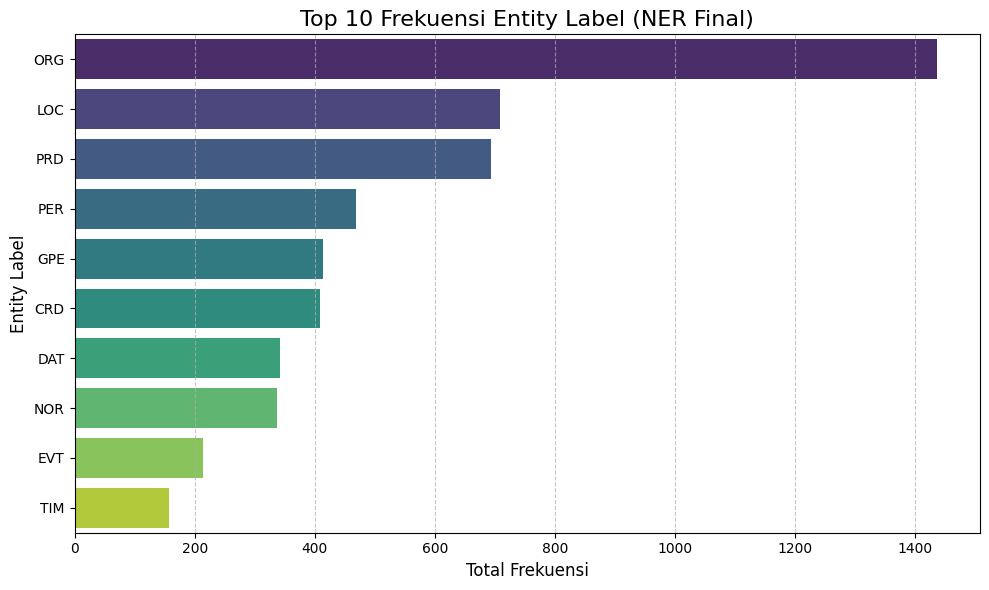

In [12]:
# --- 7. Visualisasi Frekuensi (Bar Chart Top 10) ---

image_filename = '../Data/visualisasi_ner_frekuensi_final.png'

plt.figure(figsize=(10, 6))
df_top_10 = df_counts_final.head(10)

sns.barplot(x='Count', y='Entity_Label', data=df_top_10, palette='viridis')
plt.title('Top 10 Frekuensi Entity Label (NER Final)', fontsize=16)
plt.xlabel('Total Frekuensi', fontsize=12)
plt.ylabel('Entity Label', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(image_filename)
print(f"\n✅ Visualisasi frekuensi entitas disimpan sebagai: {image_filename}")

In [16]:
import pandas as pd
from collections import defaultdict, Counter
from IPython.display import display
import numpy as np 
import ast

def safe_convert_final_entity(x):
    """Mencoba mengkonversi string JSON (jika ada) atau mengembalikan list jika sudah list."""
    if isinstance(x, list):
        return x
    if pd.isna(x) or not isinstance(x, str) or x.strip() in ('[]', ''):
        return []
    try:
        return ast.literal_eval(x)
    except:
        return []

In [ ]:
# Terapkan konversi/pemeriksaan pada kolom Entitas_NER_Final
df['Entitas_NER_List'] = df['Entitas_NER_Final'].apply(safe_convert_final_entity)


# --- 3. Mengumpulkan Kata-kata ke dalam Dictionary per Label ---

entities_by_label = defaultdict(lambda: defaultdict(int)) 

for index, row in df.iterrows():
    for entity in row['Entitas_NER_List']:
        label = entity.get('label')
        word = entity.get('entity')
        
        if label and word:
            # Menggunakan huruf kecil dan menghitung frekuensi
            entities_by_label[label][word.lower().strip()] += 1

# --- 4. Memformat Hasil ke dalam DataFrame (Tabel) ---

output_rows = []
# Urutkan label secara descending berdasarkan total kemunculan
sorted_labels = sorted(entities_by_label.keys(), 
                       key=lambda k: sum(entities_by_label[k].values()), 
                       reverse=True)

for label in sorted_labels:
    # Ambil 10 kata teratas untuk setiap label
    top_words_with_freq = Counter(entities_by_label[label]).most_common(10)
    
    # Format kata-kata menjadi string (e.g., "jakarta (20); cawang (15)")
    words_formatted = [f"{word} ({freq})" for word, freq in top_words_with_freq]
    
    # Gabungkan menjadi satu string
    word_list_str = "; ".join(words_formatted)
    
    output_rows.append({
        'Entity Label': label,
        'Top 10 Kata (Frekuensi)': word_list_str
    })

df_entity_summary = pd.DataFrame(output_rows)

# --- 5. Menampilkan Tabel Hasil ---
print("\n=================================================================")
print("TABEL RINGKASAN ENTITAS BERSIH (TOP 10 PER LABEL dari Entitas_NER_Final)")
print("=================================================================")

# Setting tampilan Pandas agar string tidak terpotong dan menampilkan tabel
with pd.option_context('display.max_colwidth', None):
    display(df_entity_summary)




TABEL RINGKASAN ENTITAS BERSIH (TOP 10 PER LABEL dari Entitas_NER_Final)


,Entity Label,Top 10 Kata (Frekuensi)
0,ORG,transjakarta (461); tempo (34); mrt (27); trans (26); pt transportasi jakarta (17); pt (11); 2025 (11); senayan (10); tj (9); persija (9)
1,LOC,halte (24); blok (23); ancol (20); senen (11); ragu (10); koridor (8); jalan (8); tanjung (8); monas (7); stop operasi (6)
2,PRD,ai (26); motor (20); bus transjakarta (19); bus listrik (18); mobil (18); halte (17); liputan6. com (15); instagram (12); rp (11); brt (11)
3,PER,ayu (37); johan budi (16); ayu wardhani (15); metro (11); pramono (11); rd (11); pram (10); pramono anung (9); rano karno (7); affa (7)
4,GPE,jakarta (237); depok (17); dki jakarta (15); jakarta selatan (14); dki (11); bekasi (10); indonesia (8); jakarta pusat (8); jakarta barat (8); bogor (7)
5,CRD,20 (31); satu (31); dua (24); tujuh (16); tiga (12); 13 (12); 30 (10); 14 (10); enam (9); 10 (8)
6,DAT,2025 (22); 2024 (19); sabtu (17); jumat (15); agustus (14); 31 agustus 2025 (12); 29 agustus 2025 (7); agustus 2025 (7); rabu (6); senin (6)
7,NOR,pemerintah (33); polda (23); polisi (14); kepolisian (11); kepala departemen (10); brimob (10); kpk (10); gubernur (8); gubernur dki jakarta (7); dpr (7)
8,EVT,hut (6); 2025 (6); bermotor (5); hari (4); libur lebaran (4); kemerdekaan (3); ##bs (3); lebaran (3); ##b (3); 2024 (3)
9,TIM,##nan (8); 24 (6); 23 59 wib (5); 17 (4); ##g (3); ##a (3); penyesuaian (3); 05 (2); ayu (2); 6a (2)


In [19]:
output_filepath_summary = '../Data/entity_summary_NER_transjakarta.csv'

# Menggunakan separator koma (default) dan tidak menyertakan indeks
df_entity_summary.to_csv(output_filepath_summary, index=False, encoding='utf-8')

print(f"\n✅ Tabel ringkasan entitas berhasil disimpan di: {output_filepath_summary}")


✅ Tabel ringkasan entitas berhasil disimpan di: ../Data/entity_summary_NER_transjakarta.csv


In [21]:
# --- 8. Visualisasi Bersih (Cuplikan 5 Baris Pertama) ---

def visualize_clean_ner(text, entities_raw):
    """Fungsi displacy yang hanya menampilkan label yang relevan."""
    RELEVANT_LABELS = ["PER", "GPE", "LOC", "ORG", "EVT", "TME", "DAT"]
    
    ents = []
    for ent in entities_raw:
        if ent['label'] in RELEVANT_LABELS:
            ents.append({
                'start': ent['start'],
                'end': ent['end'],
                'label': ent['label']
            })
    
    doc_data = {'text': text, 'ents': ents}
    
    options = {
        "ents": RELEVANT_LABELS,
        "colors": {
            "PER": "#AA96DA", "GPE": "#82CD47", "LOC": "#FF90BB",
            "ORG": "#F0E442", "EVT": "#009E73", "TME": "#5D9C59", "DAT": "#0072B2"
        }
    }
    
    # Rendering displacy (hanya berfungsi di lingkungan notebook/Colab)
    html = displacy.render(doc_data, style="ent", manual=True, options=options, jupyter=False)
    return html

print("\n--- CUPLIKAN VISUALISASI NER BERSIH (5 BARIS PERTAMA) ---")
for index, row in df.head(5).iterrows():
    # Gunakan kolom Entitas_NER_Final
    html_output = visualize_clean_ner(row['Teks_Lengkap'], row['Entitas_NER_Final'])
    display(HTML(html_output))
    print("-" * 50)

# --- 9. Menyimpan Data Final NER ---
output_filepath_final_ner = '../Data/hasil_ner_final_transjakarta.csv'
# Simpan DataFrame dengan kolom entitas mentah, fused, dan final
df.to_csv(output_filepath_final_ner, index=False, encoding='utf-8')
print(f"\n✅ Data NER Final (bersih dan terfusi) disimpan di: {output_filepath_final_ner}")


--- CUPLIKAN VISUALISASI NER BERSIH (5 BARIS PERTAMA) ---


--------------------------------------------------


--------------------------------------------------


--------------------------------------------------


--------------------------------------------------


--------------------------------------------------

✅ Data NER Final (bersih dan terfusi) disimpan di: ../Data/hasil_ner_final_transjakarta.csv
